# Basic Imports

In [1]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [2]:
%matplotlib inline

import pandas
import numpy
from matplotlib import pylab
import seaborn

import ipywidgets as ipyw

import IPython
from IPython.display import display

In [3]:
import itertools
import toolz.dicttoolz
from toolz.dicttoolz import merge

In [4]:
!git show --oneline -s HEAD

d1c7c4f Update protease_sequencing_model with FlatNormal sel_k prior.


In [5]:
import jug
jug.init("replicate_analysis.py")
import replicate_analysis

In [6]:
from replicate_analysis import replicate_pairs, parameter_sets, model_results, data
model_results = jug.value(model_results)

In [7]:
summary_frames = { d : {} for d in replicate_pairs }

for d, p in itertools.product(replicate_pairs, parameter_sets):
    sframes = []
    for mn in replicate_pairs[d]:
        counts = data.counts[mn]
        params = model_results[(mn, p)]["params"]
        preds = model_results[(mn, p)]["predictions"]
        
        sf = counts[["name"]].copy()
        sf["ec50"] = params["sel_ec50"]
        
        for g in preds:
            obs_dist = counts["counts%s" % g] / counts["counts%s" % g].sum()
            pred_dist = preds[g]["selection_dist"] / preds[g]["selection_dist"].sum()
            
            lobs_dist = numpy.log(obs_dist).clip(-9, None)
            lpred_dist = numpy.log(pred_dist).clip(-9, None)
            sf["l_dist_delta_%s" % g] = lobs_dist - lpred_dist
            sf["l_dist_delta_%s" % g][obs_dist == 0] = numpy.nan
            
        sframes.append(sf)
    
    summary_frames[d][p] = pandas.merge(*sframes, how="inner", on="name")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
grocklin_fit_results = pandas.read_pickle("161115_grocklin_fit_results.pickle")

grockin_fit_frames = {
    d : pandas.merge(
        *[grocklin_fit_results[n][["name", "ec50"]] for n in p],
        how="inner", on="name"
    )
    for d, p in replicate_pairs.items()
}

In [9]:
import scipy.stats
from scipy.stats import pearsonr
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [10]:
model_param_evaluations = {
    "pearsonr" : lambda x1, x2: scipy.stats.pearsonr(x1, x2)[0],
    "neg_mse" : lambda x1, x2: -mean_squared_error(x1, x2),
    "neg_outlier_mse" : lambda x1, x2: (
        -numpy.mean(numpy.clip(numpy.abs(x1 - x2) - 1, 0, None) ** 2))
}

# Evaluation Overview

Adding evaluation via existing `model_param_evaluations` metrics, which measure concordance of replicate experiements.

Adding evaluation of model quality via sort-of-hacky mean-square-log-delta between observed and predicted population distributions. `ms_log_d` is a per-sort-round evaluation and `sum_ms_log_d` is a sum of per-sort-round evaluations.

In [11]:
eval_records = [
    merge(
        {
            "param_set" : param_set,
        },
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        dict(param_set),
        dict(dataset=dataset),
        { 
            "fit_" + v : model_results[(dataset, param_set)]["params"].get(v, None)
            for v in ("min_selection_mass", "min_selection_rate")
        },
        { "sel_k" : float(model_results[(dataset, param_set)]["params"]["sel_k"]) },
        {
            "ms_log_d_%s" % g : numpy.nanmean(numpy.square(sf["l_dist_delta_%s_x" % g]))
            for g in range(1, 7)
        },
    )
    for dataset in summary_frames
    for param_set, sf in summary_frames[dataset].items()
]

eval_records = pandas.DataFrame.from_records(eval_records)

eval_records["neg_sum_ms_log_d"] = -eval_records[["ms_log_d_%s" % i for i in range(1, 7)]].sum(axis=1)

In [12]:
grockin_eval_records = pandas.DataFrame.from_records([
    merge(
        {
            e : ef(sf["ec50_x"], sf["ec50_y"])
            for e, ef in model_param_evaluations.items()
        },
        dict(dataset=dataset),
    )
    for dataset, sf in grockin_fit_frames.items()
])

grockin_eval_records.sort_values("dataset")

,dataset,neg_mse,neg_outlier_mse,pearsonr
1,rd2_chymo,-1.761397,-0.686568,0.583877
2,rd2_tryp,-1.704013,-0.570927,0.453168
3,rd3_chymo,-0.347277,-0.068745,0.890660
0,rd3_tryp,-0.368697,-0.054830,0.892365


# General Conclusions

There is no single conclusive "winner" in the metrics we're considering for datasest quality and replicate concordance. In general, the low-value constant homogenous leak model (1e-6) is best followed by the tuned ("global") leak rate. The constant leak model outperforms (slightly) when assessing by replicate pearsonr.

# Result ranks by measure.

Table of model ranking by measure & dataset.

In [39]:
measures = ["pearsonr", "neg_sum_ms_log_d"]
ranks = { v : [] for v in set(eval_records["min_selection_mass"])}

cols = []
for measure in measures:
    for ds, f in eval_records.groupby("dataset"):
        cols.append((measure, ds))
        
        mrank = f.sort_values(measure, ascending=False).reset_index(drop=True)["min_selection_mass"]
        for m, r in zip(mrank, mrank.index):
            ranks[m].append(r)
            
display({ m : sorted(vs) for m, vs in ranks.items() })

display({ m : numpy.mean(vs) for m, vs in ranks.items() })

display(pandas.DataFrame(data=ranks.values(), index=ranks.keys(), columns=cols)[sorted(cols)])

{False: [0, 1, 1, 1, 2, 4, 5, 5],
 1e-07: [0, 0, 1, 1, 1, 2, 2, 3],
 1e-06: [0, 0, 0, 1, 2, 2, 3, 4],
 1e-05: [2, 4, 5, 5, 5, 5, 5, 5],
 'global': [0, 1, 2, 3, 3, 3, 3, 4],
 'per_selection': [0, 2, 3, 3, 4, 4, 4, 4]}

{False: 2.375,
 1e-07: 1.25,
 1e-06: 1.5,
 1e-05: 4.5,
 'global': 2.375,
 'per_selection': 3.0}

,"(neg_sum_ms_log_d, rd2_chymo)","(neg_sum_ms_log_d, rd2_tryp)","(neg_sum_ms_log_d, rd3_chymo)","(neg_sum_ms_log_d, rd3_tryp)","(pearsonr, rd2_chymo)","(pearsonr, rd2_tryp)","(pearsonr, rd3_chymo)","(pearsonr, rd3_tryp)"
False,1,1,1,0,4,5,2,5
1e-06,2,3,4,2,1,0,0,0
1e-05,5,5,5,5,5,4,5,2
1e-07,0,0,2,1,2,3,1,1
global,3,2,3,3,0,1,3,4
per_selection,4,4,0,4,3,2,4,3


# Model performance

Model performance on given metrics. `delta` column shows metric delta from maximum within the dataset.

In [41]:
measures = ["neg_outlier_mse", "pearsonr", "neg_sum_ms_log_d"]

for param in ("min_selection_mass",):
    rpt = eval_records.groupby(("dataset", param))[measures].max()
    delta = (rpt.groupby(rpt.index.get_level_values("dataset")).max() - rpt).rename(columns=lambda c: "delta_" + c)
    
    display(
        pandas.concat([rpt, delta], axis=1)
        .applymap( lambda v: "%.2f" % v)
    )

neg_outlier_mse pearsonr neg_sum_ms_log_d  \
dataset   min_selection_mass                                             
rd2_chymo False                        -0.85     0.54            -1.36   
          1e-07                        -0.74     0.55            -1.33   
          1e-06                        -0.73     0.56            -1.40   
          1e-05                        -0.97     0.54            -2.19   
          global                       -0.57     0.58            -1.41   
          per_selection                -0.86     0.55            -1.98   
rd2_tryp  False                        -0.90     0.38            -2.94   
          1e-07                        -0.83     0.38            -2.88   
          1e-06                        -0.33     0.52            -3.32   
          1e-05                        -1.12     0.38            -4.09   
          global                       -0.67     0.41            -3.08   
          per_selection                -0.78     0.39            -3.64   
rd3_chymo False                        -0.07     0.86            -2.73   
          1e-07                        -0.07     0.88            -2.81   
          1e-06                        -0.07     0.88            -3.27   
          1e-05                        -0.17     0.84            -4.05   
          global                       -0.08     0.86            -3.09   
          per_selection                -0.08     0.86            -2.73   
rd3_tryp  False                        -0.09     0.84            -0.33   
          1e-07                        -0.05     0.88            -0.34   
          1e-06                        -0.06     0.89            -0.39   
          1e-05                        -0.12     0.87            -1.16   
          global                       -0.08     0.86            -0.39   
          per_selection                -0.07     0.86            -0.44   

                             delta_neg_outlier_mse delta_pearsonr  \
dataset   min_selection_mass                                        
rd2_chymo False                               0.28           0.04   
          1e-07                               0.17           0.03   
          1e-06                               0.15           0.02   
          1e-05                               0.39           0.04   
          global                              0.00           0.00   
          per_selection                       0.29           0.03   
rd2_tryp  False                               0.57           0.14   
          1e-07                               0.50           0.13   
          1e-06                               0.00           0.00   
          1e-05                               0.80           0.14   
          global                              0.34           0.11   
          per_selection                       0.45           0.13   
rd3_chymo False                               0.01           0.02   
          1e-07                               0.00           0.00   
          1e-06                               0.01           0.00   
          1e-05                               0.10           0.04   
          global                              0.01           0.02   
          per_selection                       0.02           0.03   
rd3_tryp  False                               0.04           0.05   
          1e-07                               0.00           0.01   
          1e-06                               0.00           0.00   
          1e-05                               0.07           0.02   
          global                              0.03           0.03   
          per_selection                       0.02           0.03   

                             delta_neg_sum_ms_log_d  
dataset   min_selection_mass                         
rd2_chymo False                                0.03  
          1e-07                                0.00  
          1e-06                                0.07  
          1e-05                        

In [42]:
(
eval_records
.groupby(["dataset"])
.apply(lambda df: df.sort_values("neg_sum_ms_log_d", ascending=False).head(1))
.sort_values("dataset")
)

,,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
dataset,,,,,,,,,,,,,,,,,,
rd2_chymo,6,rd2_chymo,None,None,1e-07,0.107713,0.137311,0.061305,0.265757,0.353952,0.400968,-1.873912,-0.741271,"((min_selection_mass, 1e-07), (response_fn, No...",0.549816,NormalSpaceErfResponse,1.498800,-1.327005
rd2_tryp,12,rd2_tryp,None,None,1e-07,0.038485,0.097123,0.075491,0.120128,0.054418,2.492437,-2.162424,-0.831067,"((min_selection_mass, 1e-07), (response_fn, No...",0.384677,NormalSpaceErfResponse,3.442845,-2.878081
rd3_chymo,20,rd3_chymo,"[1.92008997459e-12, 8.99702155413e-12, 8.72072...",None,per_selection,0.022770,0.035797,0.071570,0.441385,0.476361,1.678411,-0.456916,-0.083642,"((min_selection_mass, per_selection), (respons...",0.856924,NormalSpaceErfResponse,1.500178,-2.726295
rd3_tryp,1,rd3_tryp,None,None,False,0.014843,0.016285,0.061988,0.088163,0.059506,0.085940,-0.487957,-0.090397,"((response_fn, NormalSpaceErfResponse), (min_s...",0.839775,NormalSpaceErfResponse,6.480054,-0.326724


In [43]:
import IPython

for g, df in eval_records.groupby("dataset"):
    IPython.display.display(g)
    IPython.display.display(df.sort_values("neg_sum_ms_log_d", ascending=False))


'rd2_chymo'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
6,rd2_chymo,None,None,1e-07,0.107713,0.137311,0.061305,0.265757,0.353952,0.400968,-1.873912,-0.741271,"((min_selection_mass, 1e-07), (response_fn, No...",0.549816,NormalSpaceErfResponse,1.498800,-1.327005
7,rd2_chymo,None,None,False,0.111213,0.145044,0.074022,0.323874,0.298908,0.404012,-2.034179,-0.849854,"((response_fn, NormalSpaceErfResponse), (min_s...",0.542697,NormalSpaceErfResponse,1.498344,-1.357074
11,rd2_chymo,None,None,1e-06,0.103967,0.131467,0.054929,0.229391,0.413454,0.468456,-1.927253,-0.726542,"((min_selection_mass, 1e-06), (response_fn, No...",0.557168,NormalSpaceErfResponse,1.499115,-1.401664
10,rd2_chymo,1.50476017975e-06,None,global,0.103552,0.131053,0.054517,0.230531,0.411971,0.481367,-1.737707,-0.574579,"((response_fn, NormalSpaceErfResponse), (min_s...",0.579250,NormalSpaceErfResponse,1.499128,-1.412992
8,rd2_chymo,"[2.34615512506e-11, 2.98590660686e-07, 5.30462...",None,per_selection,0.107514,0.137376,0.053376,0.211744,0.578262,0.888194,-2.105761,-0.861203,"((min_selection_mass, per_selection), (respons...",0.545596,NormalSpaceErfResponse,1.499429,-1.976466
9,rd2_chymo,None,None,1e-05,0.091010,0.124077,0.058598,0.357753,0.546462,1.009918,-2.286442,-0.965717,"((response_fn, NormalSpaceErfResponse), (min_s...",0.540012,NormalSpaceErfResponse,1.499977,-2.187818


'rd2_tryp'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
12,rd2_tryp,None,None,1e-07,0.038485,0.097123,0.075491,0.120128,0.054418,2.492437,-2.162424,-0.831067,"((min_selection_mass, 1e-07), (response_fn, No...",0.384677,NormalSpaceErfResponse,3.442845,-2.878081
13,rd2_tryp,None,None,False,0.044503,0.118178,0.079154,0.142368,0.074713,2.481462,-2.265716,-0.901397,"((response_fn, NormalSpaceErfResponse), (min_s...",0.378065,NormalSpaceErfResponse,2.964527,-2.940378
16,rd2_tryp,7.57855467531e-07,None,global,0.036693,0.091324,0.072443,0.109734,0.049976,2.718206,-1.924896,-0.669426,"((response_fn, NormalSpaceErfResponse), (min_s...",0.408872,NormalSpaceErfResponse,3.603603,-3.078376
17,rd2_tryp,None,None,1e-06,0.033520,0.081511,0.068569,0.094740,0.040243,3.000550,-1.320959,-0.327464,"((min_selection_mass, 1e-06), (response_fn, No...",0.517265,NormalSpaceErfResponse,5.144419,-3.319133
14,rd2_tryp,"[7.22398093384e-11, 8.93970783657e-07, 3.57573...",None,per_selection,0.036950,0.091384,0.072443,0.102089,0.034463,3.303846,-2.083360,-0.776756,"((min_selection_mass, per_selection), (respons...",0.392237,NormalSpaceErfResponse,4.489145,-3.641175
15,rd2_tryp,None,None,1e-05,0.030533,0.068153,0.069252,0.153596,0.143292,3.624612,-2.637162,-1.124237,"((response_fn, NormalSpaceErfResponse), (min_s...",0.380826,NormalSpaceErfResponse,6.500010,-4.089437


'rd3_chymo'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
20,rd3_chymo,"[1.92008997459e-12, 8.99702155413e-12, 8.72072...",None,per_selection,0.022770,0.035797,0.071570,0.441385,0.476361,1.678411,-0.456916,-0.083642,"((min_selection_mass, per_selection), (respons...",0.856924,NormalSpaceErfResponse,1.500178,-2.726295
19,rd3_chymo,None,None,False,0.022761,0.035326,0.071696,0.440461,0.460771,1.697356,-0.413204,-0.074957,"((response_fn, NormalSpaceErfResponse), (min_s...",0.864780,NormalSpaceErfResponse,1.499562,-2.728371
18,rd3_chymo,None,None,1e-07,0.021635,0.031334,0.068021,0.395559,0.414501,1.877461,-0.403787,-0.068627,"((min_selection_mass, 1e-07), (response_fn, No...",0.878394,NormalSpaceErfResponse,1.634060,-2.808511
22,rd3_chymo,1.24399063644e-06,None,global,0.021781,0.033637,0.066879,0.385150,0.491182,2.091276,-0.445649,-0.081338,"((response_fn, NormalSpaceErfResponse), (min_s...",0.860170,NormalSpaceErfResponse,1.668647,-3.089904
23,rd3_chymo,None,None,1e-06,0.017262,0.024126,0.040192,0.201685,0.424509,2.565764,-0.485300,-0.074304,"((min_selection_mass, 1e-06), (response_fn, No...",0.883378,NormalSpaceErfResponse,4.458356,-3.273537
21,rd3_chymo,None,None,1e-05,0.016904,0.023502,0.051177,0.465198,0.915370,2.579340,-0.640807,-0.167101,"((response_fn, NormalSpaceErfResponse), (min_s...",0.843563,NormalSpaceErfResponse,3.728371,-4.051491


'rd3_tryp'

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
1,rd3_tryp,None,None,False,0.014843,0.016285,0.061988,0.088163,0.059506,0.085940,-0.487957,-0.090397,"((response_fn, NormalSpaceErfResponse), (min_s...",0.839775,NormalSpaceErfResponse,6.480054,-0.326724
0,rd3_tryp,None,None,1e-07,0.014353,0.015354,0.050674,0.096097,0.056211,0.102670,-0.381638,-0.052279,"((min_selection_mass, 1e-07), (response_fn, No...",0.877554,NormalSpaceErfResponse,6.500006,-0.335358
5,rd3_tryp,None,None,1e-06,0.012385,0.013700,0.044818,0.082208,0.060464,0.175011,-0.404984,-0.055506,"((min_selection_mass, 1e-06), (response_fn, No...",0.889620,NormalSpaceErfResponse,6.500015,-0.388586
4,rd3_tryp,5.41588511623e-07,None,global,0.012308,0.014214,0.050705,0.072499,0.058518,0.183406,-0.443514,-0.081883,"((response_fn, NormalSpaceErfResponse), (min_s...",0.856731,NormalSpaceErfResponse,6.497819,-0.391650
2,rd3_tryp,"[1.20016109612e-11, 8.47799657038e-07, 6.35700...",None,per_selection,0.012474,0.014228,0.051149,0.071678,0.056515,0.233439,-0.421586,-0.070202,"((min_selection_mass, per_selection), (respons...",0.859942,NormalSpaceErfResponse,6.500008,-0.439483
3,rd3_tryp,None,None,1e-05,0.009997,0.012140,0.048205,0.086153,0.268852,0.737105,-0.566457,-0.117826,"((response_fn, NormalSpaceErfResponse), (min_s...",0.869000,NormalSpaceErfResponse,6.500002,-1.162454


In [44]:
def plot_eval_pair(ax, idx):
    dataset = eval_records.ix[idx]["dataset"]
    params = eval_records.ix[idx]["param_set"]
    fit_params = model_results[(dataset, params)]["params"]

    sf = summary_frames[dataset][params]

    params = dict(params)
    title = ["%s (%i)" % (dataset, idx)]
    for k in sorted(params):
        if k in fit_params:
            p = numpy.atleast_1d(fit_params[k])
            title.append("%s: %s (%s)" % (k, params[k], ",".join("%.1e" % f for f in p)))
        else:
            title.append("%s: %s" % (k, params[k]))
    title.append("sel_k: %.2f" % fit_params["sel_k"])

    ax.set_title("\n".join(title))
    
    pairplot_ec50(ax, sf)
    
def pairplot_ec50(ax, sf):
    sf.plot.hexbin("ec50_x", "ec50_y", mincnt=1, gridsize=50, ax=ax)
    data, binx, biny = numpy.histogram2d(
        sf["ec50_x"].values, sf["ec50_y"].values, bins=[-2, 0, 2, 4, 8], normed=True)
    for x in binx[1:-1]:
        ax.axvline(x, alpha=.1)
    for y in biny[1:-1]:
        ax.axhline(y, alpha=.1)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(
                binx[x] + 0.5,
                biny[y] + 0.5,
                '%.1e' % data[y, x],
                fontsize = "small",
                verticalalignment='bottom',
        
            )


# Model Scatter plots
Plots of '1e-6' vs 'global' vs 'grockin' by dataset.

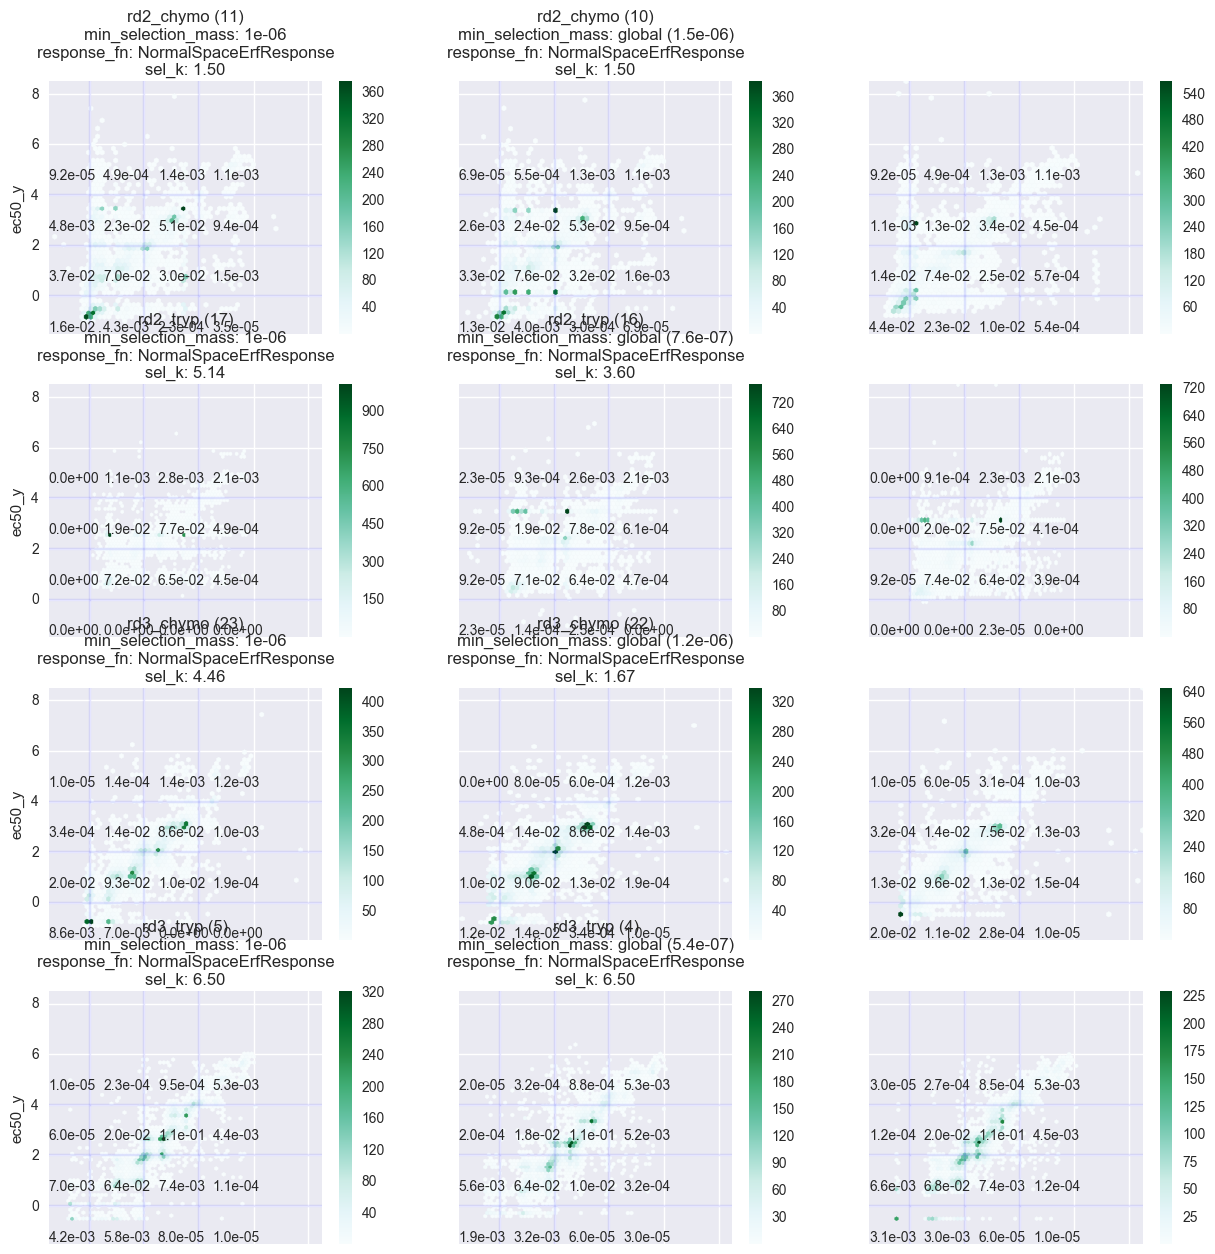

In [45]:
msm_lookup = {str(m) : m for m in list(set(eval_records["min_selection_mass"]))}
@ipyw.interact
def display_records_by_param(c1 = msm_lookup.keys(), c2 = msm_lookup.keys()):
    c1 = msm_lookup[c1]
    c2 = msm_lookup[c2]
    
    r1 = eval_records[eval_records["min_selection_mass"] == c1].sort_values("dataset")
    r2 = eval_records[eval_records["min_selection_mass"] == c2].sort_values("dataset")
    
    f, axs = pylab.subplots(len(r1), 3, squeeze=True, figsize=(15, 15), sharex=True, sharey=True)
    
    for (ax1, ax2, a3), (i1, i2) in zip(axs, zip(r1.index, r2.index)):
        plot_eval_pair(ax1, i1)
        plot_eval_pair(ax2, i2)
        pairplot_ec50(a3, grockin_fit_frames[eval_records.ix[i1]["dataset"]])

,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
3,rd3_tryp,None,None,1e-05,0.009997,0.012140,0.048205,0.086153,0.268852,0.737105,-0.566457,-0.117826,"((response_fn, NormalSpaceErfResponse), (min_s...",0.869000,NormalSpaceErfResponse,6.500002,-1.162454
0,rd3_tryp,None,None,1e-07,0.014353,0.015354,0.050674,0.096097,0.056211,0.102670,-0.381638,-0.052279,"((min_selection_mass, 1e-07), (response_fn, No...",0.877554,NormalSpaceErfResponse,6.500006,-0.335358


,dataset,neg_mse,neg_outlier_mse,pearsonr
0,rd3_tryp,-0.368697,-0.05483,0.892365


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
9,rd2_chymo,None,None,1e-05,0.091010,0.124077,0.058598,0.357753,0.546462,1.009918,-2.286442,-0.965717,"((response_fn, NormalSpaceErfResponse), (min_s...",0.540012,NormalSpaceErfResponse,1.499977,-2.187818
10,rd2_chymo,1.50476017975e-06,None,global,0.103552,0.131053,0.054517,0.230531,0.411971,0.481367,-1.737707,-0.574579,"((response_fn, NormalSpaceErfResponse), (min_s...",0.579250,NormalSpaceErfResponse,1.499128,-1.412992


,dataset,neg_mse,neg_outlier_mse,pearsonr
1,rd2_chymo,-1.761397,-0.686568,0.583877


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
15,rd2_tryp,None,None,1e-05,0.030533,0.068153,0.069252,0.153596,0.143292,3.624612,-2.637162,-1.124237,"((response_fn, NormalSpaceErfResponse), (min_s...",0.380826,NormalSpaceErfResponse,6.500010,-4.089437
17,rd2_tryp,None,None,1e-06,0.033520,0.081511,0.068569,0.094740,0.040243,3.000550,-1.320959,-0.327464,"((min_selection_mass, 1e-06), (response_fn, No...",0.517265,NormalSpaceErfResponse,5.144419,-3.319133


,dataset,neg_mse,neg_outlier_mse,pearsonr
2,rd2_tryp,-1.704013,-0.570927,0.453168


,dataset,fit_min_selection_mass,fit_min_selection_rate,min_selection_mass,ms_log_d_1,ms_log_d_2,ms_log_d_3,ms_log_d_4,ms_log_d_5,ms_log_d_6,neg_mse,neg_outlier_mse,param_set,pearsonr,response_fn,sel_k,neg_sum_ms_log_d
21,rd3_chymo,None,None,1e-05,0.016904,0.023502,0.051177,0.465198,0.915370,2.579340,-0.640807,-0.167101,"((response_fn, NormalSpaceErfResponse), (min_s...",0.843563,NormalSpaceErfResponse,3.728371,-4.051491
18,rd3_chymo,None,None,1e-07,0.021635,0.031334,0.068021,0.395559,0.414501,1.877461,-0.403787,-0.068627,"((min_selection_mass, 1e-07), (response_fn, No...",0.878394,NormalSpaceErfResponse,1.634060,-2.808511


,dataset,neg_mse,neg_outlier_mse,pearsonr
3,rd3_chymo,-0.347277,-0.068745,0.89066


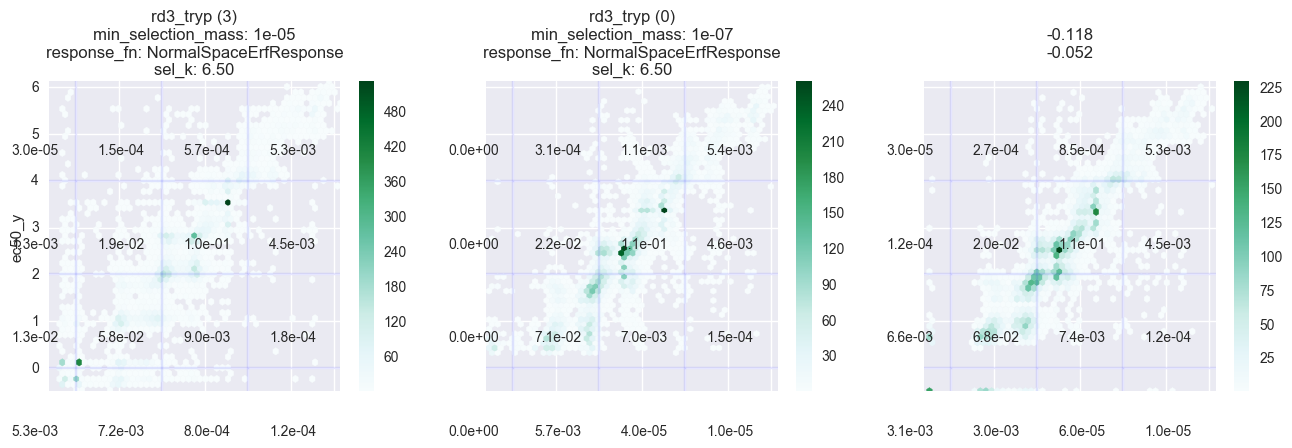

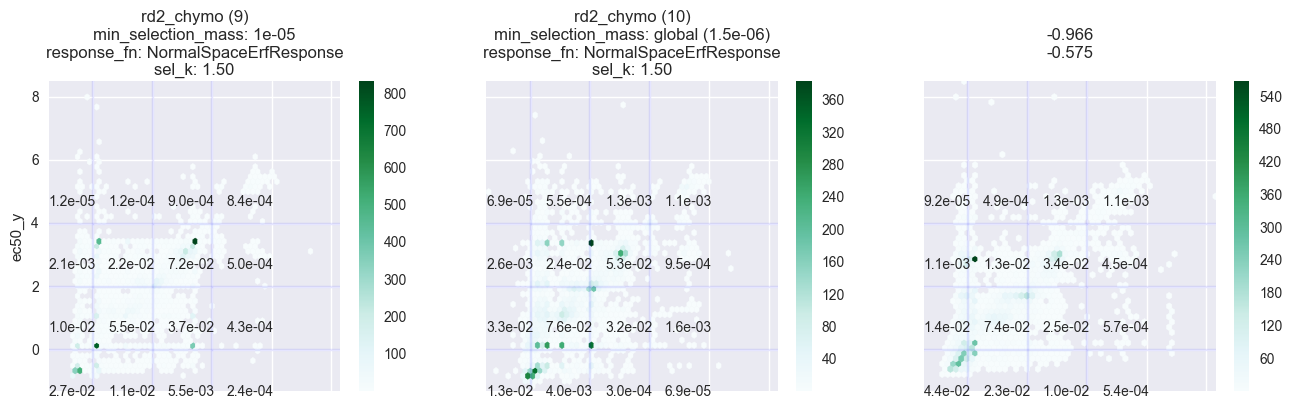

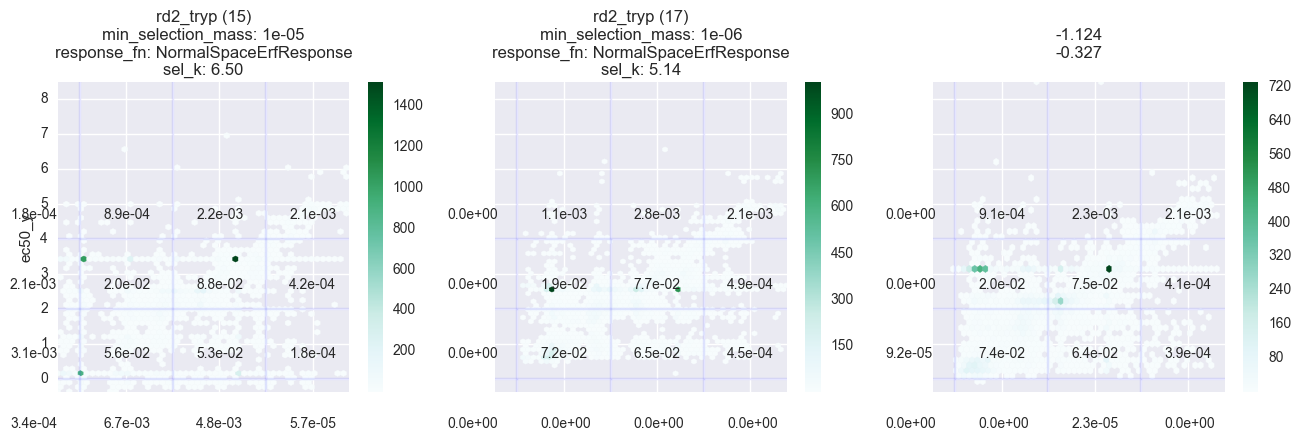

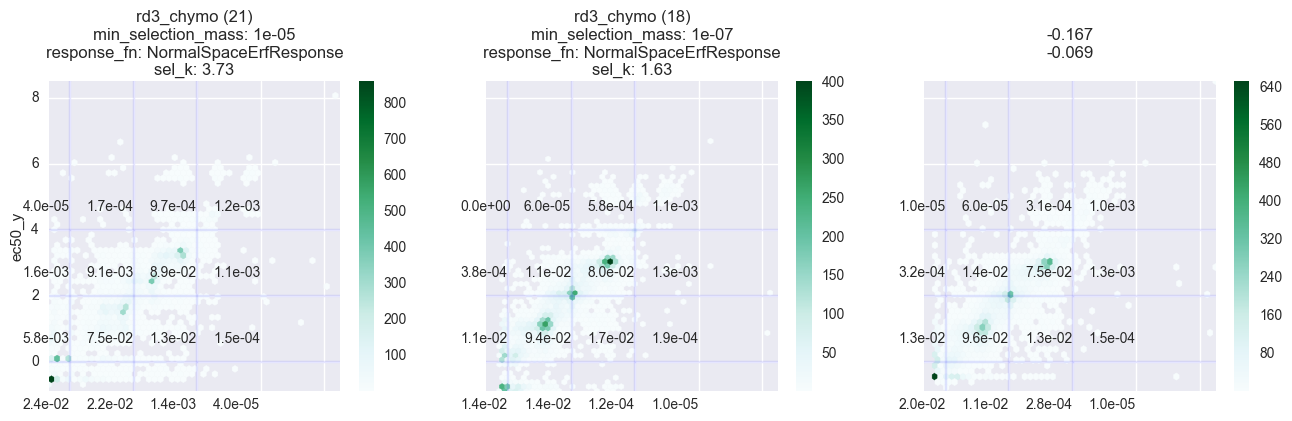

In [47]:
@ipyw.interact
def display_records(metric = list(model_param_evaluations) + ["neg_sum_ms_log_d"]):
    
    for dataset in list(pandas.unique(eval_records["dataset"])):


        ss = eval_records[eval_records["dataset"] == dataset].sort_values(metric)
        b_i = ss.index[0]
        w_i = ss.index[-1]

        display(ss.iloc[[0, -1]])
        display(grockin_eval_records[grockin_eval_records["dataset"] == dataset])

        f, (a1, a2, a3) = pylab.subplots(ncols=3, sharex=True, sharey=True, figsize=(16, 4))
        plot_eval_pair(a1, b_i)
        plot_eval_pair(a2, w_i)
        
        pairplot_ec50(a3, grockin_fit_frames[dataset])
        
        a3.set_title("%.3f\n%.3f\n" % (
                ss.iloc[0][metric],
                ss.iloc[-1][metric],
                #grockin_eval_records.query("dataset == '%s'" % dataset).iloc[0][metric]
        ))